# Beatbot

I had the idea a few years ago to build an app that would process audio of beatboxing (vocal percussion), do some magic, then spit out a new audio track composed of drum noises.

A couple months ago that I got the time to get serious about working on this idea. This ended up being a super interesting data science / signal processing problem closely related to the well documented area of speech-processing algorithims. This was my first project that involved a lot more research than heads-down coding time.

So far I've built an algorithm that works decently on quality beatboxing tracks.

I call this tool "beatbot". Here's how it works.

## Table of contents

* Beat location
* Beat classification
* Beat replacement

## Part I: Beat location

The first step in beatbot is to locate all the beats in the given audio wave. Here's an example beatbox track. 

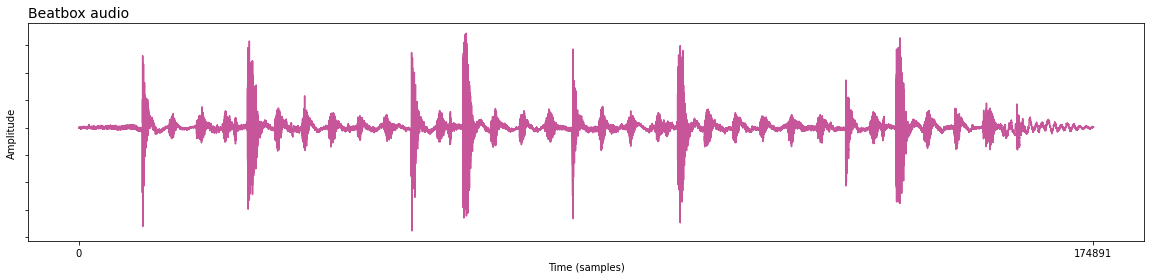

In [1]:
import IPython
import librosa
from src import plot_utils

%matplotlib inline

BEATBOX_AUDIO_FILE = 'data/beatbox_1.wav'

# Load audio
audio, sample_rate = librosa.load(BEATBOX_AUDIO_FILE, mono=True)

# Display audio (visual and auditory)
plot_utils.plot(y=audio, title='Beatbox audio', xlabel='Time (samples)', ylabel='Amplitude')
IPython.display.Audio(BEATBOX_AUDIO_FILE)

Visually, we can already begin to see where the beats are located in the waveform, but there are too many points and too much noise to easily work out where the beats begin and end.

To get a get a cleaner representation showing where our beats lie, we'll start by taking a look at the the frequencies in this audio track over time. We'll do this by applying the "Fourier transform" to small, overlapping windows of our audio wave.

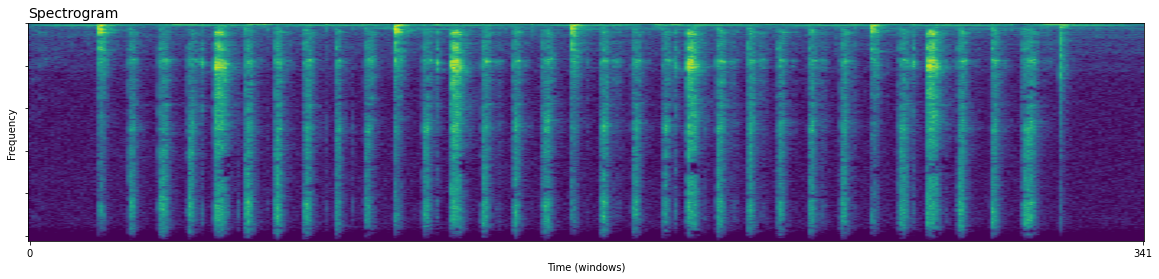

In [2]:
import numpy as np

# Windows of audio 23ms long with 12ms of overlap
WINDOW_SIZE = 1024
WINDOW_OVERLAP = 512

# Take the 'short time' Fourier transform of the audio signal
spectrogram = librosa.stft(y=audio, win_length=WINDOW_SIZE, hop_length=WINDOW_OVERLAP)

# Convert imaginary numbers to real numbers
spectrogram = np.abs(spectrogram)

# Convert from amplitude to decibels (decibels are logarithmic and better for humans)
spectrogram = librosa.amplitude_to_db(spectrogram)

plot_utils.heatmap(data=spectrogram, title='Spectrogram', xlabel='Time (windows)', ylabel='Frequency')

In this visualization of our audio frequencies over time (known as a spectrogram), we can clearly see where each beat is located. Yellower colors indicate loudness while bluer colors indicate quietness. Positions near the top represent high frequencies, while lower positions show low frequencies.

This visualization represents what us humans are hearing far better than the raw waveform. Humans hear frequencies with logarithmic intensity, meaning that we're that we're able to distinguish subtle differences in high frequencies but only large differences in low frequencies. We're able to well represent that aspect of human hearing in our spectrogram when we convert our raw amplitude values to decibel values which lie on a logarithmic scale like human hearing.

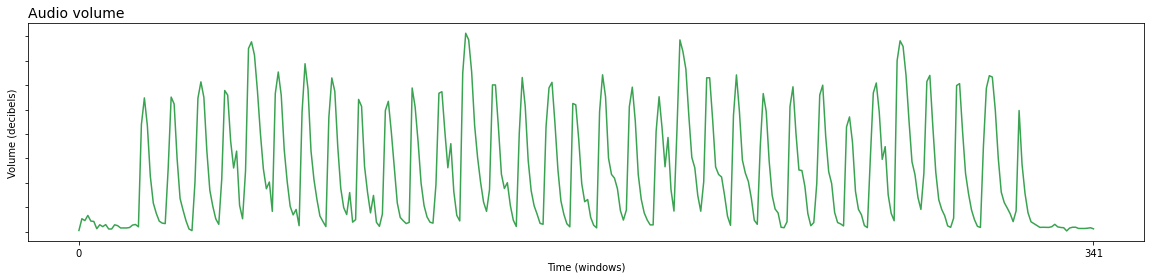

In [3]:
# Sum the spectrogram by column
volume = np.sum(spectrogram, axis=0)

plot_utils.plot(volume, title='Audio volume', xlabel='Time (windows)', ylabel='Volume (decibels)')

Finally, by summing our spectrogram by column, we get a great representation of how loud the audio is over time. We can see 33 clear peaks each representing a beat in our audio. All we have to do now is write some code to automatically find where each of these peaks begins and ends.

A core tool for this process will be SciPy's peak finding utility which can take a signal and a prominence value then return the location of all the peaks with at least that prominence. The only problem is that for any given audio track, we won't know what prominence value to use. To solve this, we'll just try a bunch and see what the most popular result is!

Most frqeuent number of peaks: 33


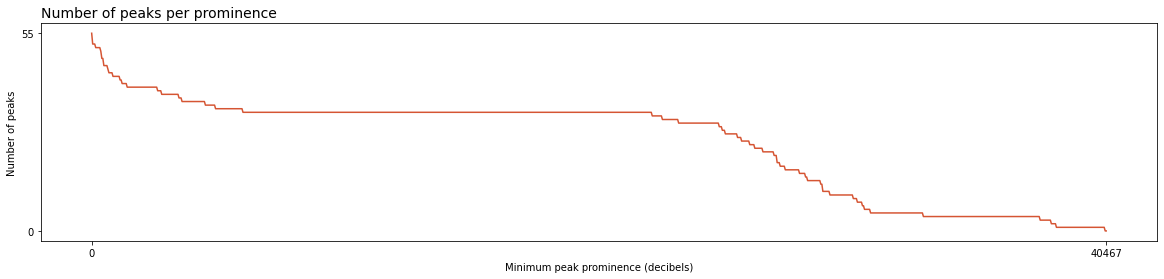

In [4]:
import scipy
import matplotlib.pyplot as plt

MIN_PROMINENCE = 0
MAX_PROMINENCE = np.max(volume) - np.min(volume)
NUM_PROMINENCES = 1000

# Create an array of prominence values
prominences = np.linspace(MIN_PROMINENCE, MAX_PROMINENCE, NUM_PROMINENCES)

# For each prominence value, calculate the # of peaks of at least that prominence
num_peaks = []
for prominence in prominences:
    peak_data = scipy.signal.find_peaks(volume, prominence=prominence)
    num_peaks.append(len(peak_data[0]))
    
# Calculate the most frequent peak quantity
most_frequent_num_peaks = np.argmax(np.bincount(num_peaks)) 

print('Most frqeuent number of peaks:', most_frequent_num_peaks)

plot_utils.plot(
    x=prominences,
    y=num_peaks,
    title='Number of peaks per prominence',
    xlabel='Minimum peak prominence (decibels)',
    ylabel='Number of peaks',
    show_yticks=True
)

That long horizontal flat line that can be seen in the graph lies exactly at 33 peaks, the expected number of beats in the audio! This method of trying many different prominence values shows us that these 33 peaks are the most significant of any of the peaks in the volume signal.

From here, we can work backwards a little bit and extract the full peak data from these 33 peaks.

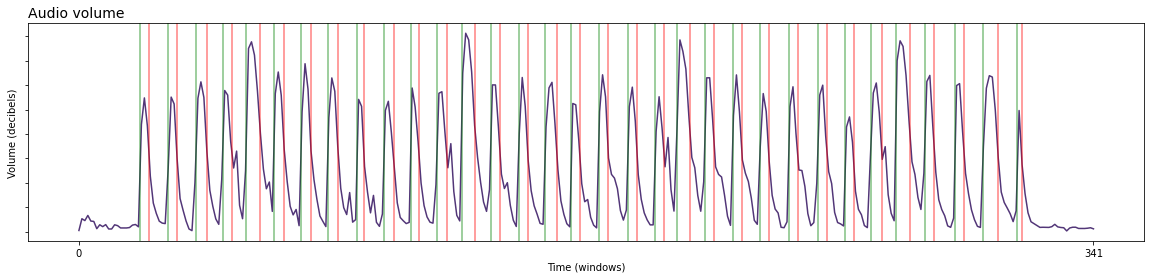

In [5]:
# Define the starts and ends of peak to be the intersection of 50% of the peak's prominence
PROMINENCE_MEASURING_POINT = 0.5

# Get a prominence value for which there are 33 peaks
prominence_index = np.where(np.array(num_peaks) == most_frequent_num_peaks)[0][0]
prominence = prominences[prominence_index]

# Calculate starts and ends of each peak
peak_data = scipy.signal.find_peaks(volume, prominence=prominence, width=0, rel_height=PROMINENCE_MEASURING_POINT)
peak_starts = peak_data[1]['left_ips']
peak_ends = peak_data[1]['right_ips']

# Plot audio volume along with beat starts and ends
plot_utils.plot(volume, title='Audio volume', xlabel='Time (windows)', ylabel='Volume (decibels)', show=False)
for peak_start, peak_end in zip(peak_starts, peak_ends):
    plt.axvline(peak_start, c='green', alpha=0.5)
    plt.axvline(peak_end, c='red', alpha=0.5)
plt.show()

And just like that, we have the locations of each beat. The last thing to do is scale these location markers from windows back to samples to extract the beats from the original audio.

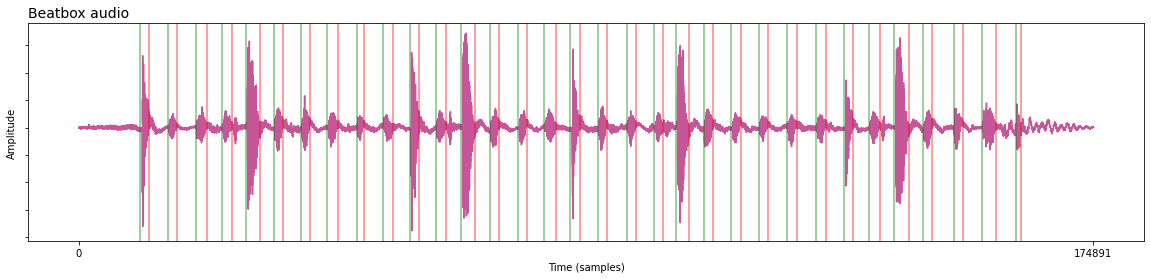

In [6]:
beat_starts = librosa.frames_to_samples(peak_starts, hop_length=WINDOW_OVERLAP)
beat_ends = librosa.frames_to_samples(peak_ends, hop_length=WINDOW_OVERLAP)

plot_utils.plot(y=audio, title='Beatbox audio', xlabel='Time (samples)', ylabel='Amplitude', show=False)
for beat_start, beat_end in zip(beat_starts, beat_ends):
    plt.axvline(beat_start, c='green', alpha=0.5)
    plt.axvline(beat_end, c='red', alpha=0.5)
plt.show()

## Part II: Beat classification

Now that we the locations of all of the beats in the track, we need to determine which sounds represent the same vocal percussion sound. If the beatboxer records audio that sounds like "pft ts kuh ts pft ts kuh ts", the job of the beat classifier is to return the pattern "0 1 2 1 0 1 2 1".

To start off, lets look at our beats.

In [ ]:
from src import multi_plot_utils

beats = []
for beat_start, beat_end in zip(beat_starts, beat_ends):
    beat = audio[beat_start:beat_end]
    beats.append(beat)

multi_plot_utils.multi_plot(beats, title='Beats')